In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import torch

In [152]:
conn = sqlite3.connect('fantasy_football_data.db')

In [164]:
# query to get average stats per game over last 2 years
# I tested both 3 years and 2 years of stats and 2 years performed better so that's why I switched to 2 years
player_stats_pg = pd.read_sql('''
    WITH sum_stats AS (
        SELECT 
            Player, Year, Tm, FantPos, Age, 
            SUM(G) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "G",
            SUM(GS) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "GS",
            SUM(Cmp) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Cmp",
            SUM(Pass_Att) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Pass_Att",
            SUM(Pass_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Pass_Yds",
            SUM(Pass_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Pass_TD",
            SUM(Int) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Int",
            SUM(Rush_Att) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rush_Att",
            SUM(Rush_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rush_Yds",
            SUM("Y/A") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Y/A",
            SUM(Rush_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rush_TD",
            SUM(Tgt) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Tgt",
            SUM(Rec) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rec",
            SUM(Rec_Yds) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rec_Yds",
            SUM("Y/R") OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Y/R",
            SUM(Rec_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Rec_TD",
            SUM(Fmb) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Fmb",
            SUM(FL) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "FL",
            SUM(Tot_TD) OVER (PARTITION BY Player ORDER BY Year ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS "Tot_TD",
            PPR/G,
            PPR,
            LAG(Tm, 1) OVER (PARTITION BY Player ORDER BY Year) AS Tm_Last_Yr
        FROM
            player_stats)
        
    SELECT
        Player, Year, Tm, FantPos, Age, G, GS, GS/G, Cmp/G, Pass_Att/G, Pass_Yds/G, Pass_TD/G, Int/G, Rush_Att/G, Rush_Yds/G, "Y/A",
        Rush_TD/G, Tgt/G, Rec/G, Rec_Yds/G, "Y/R", Rec_TD/G, Fmb/G, FL/G, Tot_TD/G, "PPR/G", PPR, Tm_Last_Yr
    FROM
        sum_stats
        '''
, conn)
player_stats_pg['Changed_Teams'] = np.where(player_stats_pg['Tm'] != player_stats_pg['Tm_Last_Yr'], 1, 0)
player_stats_pg['PPR/G'].fillna(0, inplace=True)
player_stats_pg['GS/G'] = player_stats_pg['GS']/player_stats_pg['G']
player_stats_pg.query('Year > 2016', inplace=True)

rookies = player_stats_pg[player_stats_pg['G'].isnull()] # saving rookies for later
player_stats_pg.dropna(subset=['G'], inplace=True)

player_stats_pg_2024 = player_stats_pg[player_stats_pg['Year']==2024] # saving 2024 stats for final predictions

player_stats_pg.head()

,Player,Year,Tm,FantPos,Age,G,GS,GS/G,Cmp/G,Pass_Att/G,...,Rec_Yds/G,Y/R,Rec_TD/G,Fmb/G,FL/G,Tot_TD/G,PPR/G,PPR,Tm_Last_Yr,Changed_Teams
1,A.J. Brown,2020,TEN,WR,23.0,16.0,11.0,0.687500,0.0,0.000000,...,65.687500,20.21,0.500000,0.062500,0.000000,0.562500,17.678571,247.5,TEN,0
2,A.J. Brown,2021,TEN,WR,24.0,30.0,23.0,0.766667,0.0,0.000000,...,70.866667,35.57,0.633333,0.100000,0.033333,0.700000,13.915385,180.9,TEN,0
3,A.J. Brown,2022,PHI,WR,25.0,27.0,25.0,0.925926,0.0,0.074074,...,72.000000,29.15,0.592593,0.074074,0.037037,0.629630,17.623529,299.6,TEN,1
4,A.J. Brown,2023,PHI,WR,26.0,30.0,29.0,0.966667,0.0,0.066667,...,78.833333,30.79,0.533333,0.066667,0.066667,0.533333,17.035294,289.6,PHI,0
5,A.J. Brown,2024,PHI,WR,27.0,34.0,33.0,0.970588,0.0,0.000000,...,86.823529,30.74,0.529412,0.117647,0.117647,0.529412,0.000000,NaN,PHI,0


In [5]:
# splitting by position
# even though before this didn't seem to make much of a difference, so I'm going to still try it
qb_stats_pg = player_stats_pg[player_stats_pg['FantPos']=='QB'].dropna().reset_index(drop=True) # dropna drops 2024 data
wr_stats_pg = player_stats_pg[player_stats_pg['FantPos']=='WR'].dropna().reset_index(drop=True)
rb_stats_pg = player_stats_pg[player_stats_pg['FantPos']=='RB'].dropna().reset_index(drop=True)
te_stats_pg = player_stats_pg[player_stats_pg['FantPos']=='TE'].dropna().reset_index(drop=True)

In [6]:
qb_stats_pg.head()

,Player,Year,Tm,FantPos,Age,G,GS,GS/G,Cmp/G,Pass_Att/G,...,Rec_Yds/G,Y/R,Rec_TD/G,Fmb/G,FL/G,Tot_TD/G,PPR/G,PPR,Tm_Last_Yr,Changed_Teams
0,A.J. McCarron,2017,CIN,QB,27.0,8.0,3.0,0.375,9.875,14.875,...,0.0,0.0,0.0,0.125,0.125,0.00,0.866667,2.6,CIN,0
1,A.J. McCarron,2018,OAK,QB,28.0,4.0,0.0,0.000,1.750,3.500,...,0.0,0.0,0.0,0.000,0.000,0.00,0.050000,0.1,CIN,1
2,A.J. McCarron,2019,HOU,QB,29.0,5.0,0.0,0.000,1.600,3.400,...,0.0,0.0,0.0,0.200,0.000,0.00,8.450000,16.9,OAK,1
3,A.J. McCarron,2020,HOU,QB,30.0,4.0,1.0,0.250,5.500,10.000,...,0.0,0.0,0.0,0.250,0.000,0.25,0.400000,0.8,HOU,0
4,A.J. McCarron,2023,CIN,QB,33.0,4.0,1.0,0.250,5.500,9.500,...,0.0,0.0,0.0,0.000,0.000,0.25,0.400000,0.8,HOU,1


In [7]:
corr_mat = qb_stats_pg.dropna().drop(['Player', 'Year', 'Tm', 'FantPos', 'Tm_Last_Yr'], axis=1).corr()
corr_mat['PPR/G'].sort_values(ascending=False)
# much better correlation scores than when the stats weren't per game

PPR/G            1.000000
PPR              0.878407
Pass_TD/G        0.618939
GS               0.618009
Pass_Yds/G       0.595282
G                0.576521
Cmp/G            0.561965
GS/G             0.557919
Pass_Att/G       0.544045
Rush_Att/G       0.451839
Rush_Yds/G       0.380412
Rush_TD/G        0.363639
Tot_TD/G         0.357026
Fmb/G            0.317349
Y/A              0.247419
FL/G             0.218502
Int/G            0.210047
Y/R              0.068179
Rec_TD/G        -0.020003
Age             -0.031431
Tgt/G           -0.039316
Rec/G           -0.044036
Rec_Yds/G       -0.046480
Changed_Teams   -0.331969
Name: PPR/G, dtype: float64

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
# qb features
qb_features_pg = qb_stats_pg[['Year', 'GS/G', 'Cmp/G', 'Pass_Att/G', 'Pass_Yds/G', 'Pass_TD/G', 'Int/G', 'Rush_Att/G', 'Rush_Yds/G', 'Rush_TD/G', 'Changed_Teams']]
qb_info_pg = qb_stats_pg[['Player', 'Year', 'Tm', 'FantPos', 'Age']]
qb_PPR_pg = qb_stats_pg[['Year','PPR/G']]

# scaling the data
scaler_qb = StandardScaler()
qb_features_pg = pd.DataFrame(scaler_qb.fit_transform(qb_features_pg), columns=qb_features_pg.columns)
scalerPPR_qb = StandardScaler() # need this to unscale the data later
qb_PPR_pg = pd.DataFrame(scalerPPR_qb.fit_transform(qb_PPR_pg['PPR/G'].values.reshape(-1,1)), columns=['PPR/G'])
qb_features_pg['Year'] = qb_stats_pg['Year']
qb_features_pg['Changed_Teams'] = qb_stats_pg['Changed_Teams']
qb_PPR_pg['Year'] = qb_stats_pg['Year']

In [10]:
qb_features_pg.head()

,Year,GS/G,Cmp/G,Pass_Att/G,Pass_Yds/G,Pass_TD/G,Int/G,Rush_Att/G,Rush_Yds/G,Rush_TD/G,Changed_Teams
0,2017,-0.811949,-0.654155,-0.739144,-0.669438,-0.387358,-0.937957,-0.490122,-0.566970,-0.789042,0
1,2018,-1.814809,-1.674574,-1.676053,-1.650139,-1.488015,-1.627074,-1.446103,-0.885309,-0.789042,1
2,2019,-1.814809,-1.693412,-1.684290,-1.668612,-1.488015,-1.627074,-1.118338,-0.918169,-0.789042,1
3,2020,-1.146236,-1.203611,-1.140676,-1.196463,-1.488015,-0.937957,-0.353553,-0.125403,1.016209,0
4,2023,-1.146236,-1.203611,-1.181859,-1.163863,-1.488015,-0.937957,-0.763259,-0.084327,1.016209,1


In [11]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [12]:
# 12 fold cross validation
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [13]:
# linear regression only qbs
lr = LinearRegression()
results = cross_validate(lr, qb_features_pg.drop('Year', axis=1), qb_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.50186344 0.47996184 0.49810038 0.50988136 0.49522335 0.51136986
 0.48427076 0.49363875 0.50163865 0.49064234 0.50382126 0.49282461]
Test MSE: [0.46242629 0.71360307 0.50915104 0.38367375 0.55229533 0.35857879
 0.6658281  0.56705995 0.47003911 0.59273539 0.43978869 0.58063219]
Mean Train MSE: 0.4969363832713755
Mean Test MSE: 0.5246509762142048


In [14]:
from sklearn.ensemble import GradientBoostingRegressor

In [15]:
# gradient boosted regression only qbs
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.001,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)
results = cross_validate(gbr, qb_features_pg.drop('Year', axis=1), qb_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.28796646 0.26439254 0.27715836 0.29321368 0.28771454 0.29047384
 0.28014601 0.27969279 0.28117211 0.2832954  0.27833937 0.26927007]
Test MSE: [0.43357522 0.76408332 0.68691851 0.39607378 0.54880681 0.35883399
 0.65397365 0.67472089 0.65762243 0.61445652 0.52339951 0.70443705]
Mean Train MSE: 0.28106959617304134
Mean Test MSE: 0.5847418076614639


In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
# same neural network as before
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
def train(model, criterion, optmizer, num_epochs, X_train, y_train):
    model.train()
    for epoch in range(num_epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return

def evaluate(model, X_train, y_train, X_test, y_test):
    model.eval()  
    with torch.no_grad():  # No need to compute gradients for evaluation
        train_predict = model(X_train)
        test_predict = model(X_test)

        train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())
        test_mse = mean_squared_error(y_test.numpy(), test_predict.numpy())
    return train_mse, test_mse

In [18]:
# setting up data and parameters
X_tensor = torch.tensor(qb_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(qb_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
learning_rate = 0.001
num_epochs = 1000
input_size = X_tensor.shape[1]
hidden_size = 64
output_size = 1
criterion = nn.MSELoss()
model = SimpleNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# cross validation
fold_results = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
    X_train = X_tensor[train_idx]
    y_train = y_tensor[train_idx]
    X_test = X_tensor[test_idx]
    y_test = y_tensor[test_idx]
    
    # initialize the model, loss function, and optimizer
    model = SimpleNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # train the model
    train(model, criterion, optimizer, num_epochs, X_train, y_train)
    
    # validate the model
    val_loss = evaluate(model, X_train, y_train, X_test, y_test)
    print(f'Fold {fold + 1}')
    print(f'Train MSE: {val_loss[0]}')
    print(f'Test MSE: {val_loss[1]}\n')
    fold_results.append(val_loss)

fold_results = np.array(fold_results)
print(f'Mean Train Loss: {np.mean(fold_results[:,0])}')
print(f'Mean Test Loss: {np.mean(fold_results[:,1])}')

Fold 1
Train MSE: 0.3169971704483032
Test MSE: 0.43579140305519104

Fold 2
Train MSE: 0.29985761642456055
Test MSE: 0.72145015001297

Fold 3
Train MSE: 0.2977049648761749
Test MSE: 0.7089524269104004

Fold 4
Train MSE: 0.3067799508571625
Test MSE: 0.5807114243507385

Fold 5
Train MSE: 0.31775298714637756
Test MSE: 0.5987598299980164

Fold 6
Train MSE: 0.35645362734794617
Test MSE: 0.4058266878128052

Fold 7
Train MSE: 0.3262331187725067
Test MSE: 0.7256878018379211

Fold 8
Train MSE: 0.3244520425796509
Test MSE: 0.6953471302986145

Fold 9
Train MSE: 0.29320353269577026
Test MSE: 0.5972195863723755

Fold 10
Train MSE: 0.2736991047859192
Test MSE: 0.7615899443626404

Fold 11
Train MSE: 0.3253384232521057
Test MSE: 0.45826640725135803

Fold 12
Train MSE: 0.30548620223999023
Test MSE: 0.5301337838172913

Mean Train Loss: 0.31199654936790466
Mean Test Loss: 0.6016446948051453


In [19]:
# 2023 data
qb_features_pg_2023 = qb_features_pg[qb_features_pg['Year']==2023].drop('Year', axis=1)
qb_PPR_pg_2023 = qb_PPR_pg[qb_PPR_pg['Year']==2023].drop('Year', axis=1)
qb_info_pg_2023 = qb_info_pg[qb_info_pg['Year']==2023]

In [20]:
# train and test data
X_train = torch.tensor(qb_features_pg[qb_features_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(qb_PPR_pg[qb_PPR_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(qb_features_pg_2023.values, dtype=torch.float32)
y_test = torch.tensor(qb_PPR_pg_2023.values, dtype=torch.float32)

# parameters
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

model.train()
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval()  
with torch.no_grad():  # don't need to compute gradients for evaluation
    train_predict = model(X_train)
    test_predict = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())
    test_mse = mean_squared_error(y_test.numpy(), test_predict.numpy())

print(f'Train Loss: {train_mse}')
print(f'Test Loss: {test_mse}')

Epoch [100/1000], Loss: 0.4807
Epoch [200/1000], Loss: 0.4381
Epoch [300/1000], Loss: 0.4149
Epoch [400/1000], Loss: 0.3968
Epoch [500/1000], Loss: 0.3808
Epoch [600/1000], Loss: 0.3644
Epoch [700/1000], Loss: 0.3482
Epoch [800/1000], Loss: 0.3327
Epoch [900/1000], Loss: 0.3163
Epoch [1000/1000], Loss: 0.2979
Train Loss: 0.29774534702301025
Test Loss: 0.6954985857009888


In [21]:
# saving predictions
result = pd.DataFrame({'Actual PPR/G': qb_PPR_pg_2023.values.flatten(), 'Predicted PPR/G': test_predict.flatten()})
result = pd.concat([qb_info_pg_2023.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['Actual PPR/G'] = qb_stats_pg['PPR/G'][qb_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR/G'] = scalerPPR_qb.inverse_transform(result['Predicted PPR/G'].values.reshape(-1,1))
result['Actual PPR'] = qb_stats_pg['PPR'][qb_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR'] = result['Predicted PPR/G']*qb_stats_pg['GS/G'][qb_stats_pg['Year']==2023].reset_index(drop=True)*16
result['Predicted Rank'] = result['Predicted PPR/G'].rank(ascending=False, method='min').astype(int)
result['Actual Rank'] = result['Actual PPR/G'].rank(ascending=False, method='min').astype(int)
result.sort_values('Predicted Rank', inplace=True)

result.head()

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Predicted Rank,Actual Rank
24,Jalen Hurts,2023,PHI,QB,25.0,20.988235,26.266623,356.8,420.265961,1,2
55,Patrick Mahomes,2023,KAN,QB,28.0,17.512500,21.456522,280.2,343.304352,2,12
17,Deshaun Watson,2023,CLE,QB,28.0,14.466667,20.806618,86.8,332.905884,3,23
41,Kyler Murray,2023,ARI,QB,26.0,18.300000,20.675636,146.4,330.810181,4,9
36,Justin Herbert,2023,LAC,QB,25.0,18.015385,19.946739,234.2,319.147827,5,10


The models trained on data split by position were all overfit and performed quite bad on the test data. In addition the cross validation was inconsistent. I think this may be due to the fact that splitting up by position results in less train and test data. I'm going predicting PPR/G without splitting up by position.

In [22]:
corr_mat = player_stats_pg.drop(['Player', 'Year', 'Tm', 'FantPos', 'Tm_Last_Yr'], axis=1).corr()
corr_mat['PPR/G'].sort_values(ascending=False)

PPR/G            1.000000
PPR              0.924478
GS/G             0.506338
GS               0.486816
Tot_TD/G         0.472692
Rec/G            0.375526
Rec_Yds/G        0.366811
Tgt/G            0.358360
Pass_TD/G        0.355057
Pass_Yds/G       0.342726
Fmb/G            0.342721
Cmp/G            0.333658
Pass_Att/G       0.329776
Rec_TD/G         0.323269
FL/G             0.304385
Rush_TD/G        0.301223
Rush_Yds/G       0.296987
Rush_Att/G       0.285529
Int/G            0.263266
Y/A              0.232757
G                0.229862
Age              0.056670
Y/R              0.034939
Changed_Teams   -0.195635
Name: PPR/G, dtype: float64

In [167]:
# player features
player_features_pg = player_stats_pg.drop(['Player', 'Tm', 'FantPos', 'Age', 'PPR', 'PPR/G', 'Tm_Last_Yr'], axis=1)
player_info_pg = player_stats_pg[['Player', 'Year', 'Tm', 'FantPos', 'Age']]
player_PPR_pg = player_stats_pg[['Year', 'PPR/G']][player_stats_pg['Year'] < 2024].reset_index(drop=True)

# scaling the data
scaler = StandardScaler()
player_features_pg = pd.DataFrame(scaler.fit_transform(player_features_pg), columns=player_features_pg.columns)
scalerPPR = StandardScaler() # using a different scaler so I can unscale the data later
player_PPR_pg = pd.DataFrame(scalerPPR.fit_transform(player_PPR_pg['PPR/G'].values.reshape(-1,1)), columns=['PPR/G'])
player_features_pg['Year'] = player_stats_pg['Year'].reset_index(drop=True)
player_features_pg['Changed_Teams'] = player_stats_pg['Changed_Teams'].reset_index(drop=True)
player_PPR_pg['Year'] = player_stats_pg['Year'][player_stats_pg['Year'] < 2024].reset_index(drop=True)

# saving 2024 data
player_features_pg_2024 = player_features_pg[player_features_pg['Year'] == 2024].reset_index(drop=True).drop('Year', axis=1)
player_features_pg = player_features_pg[player_features_pg['Year'] < 2024].reset_index(drop=True)
player_info_pg_2024 = player_info_pg[player_info_pg['Year'] == 2024].reset_index(drop=True)
player_info_pg = player_info_pg[player_info_pg['Year'] < 2024].reset_index(drop=True)

In [168]:
# linear regression all players
lr = LinearRegression()
results = cross_validate(lr, player_features_pg.drop('Year', axis=1), player_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.37238625 0.3687807  0.36888109 0.35848415 0.36333834 0.36590893
 0.36375157 0.36628208 0.3663944  0.36180454 0.36902771 0.36758561]
Test MSE: [0.30228664 0.34556049 0.34286202 0.45771646 0.4041706  0.37650123
 0.39857489 0.3695095  0.37136084 0.42655277 0.33986181 0.36105637]
Mean Train MSE: 0.3660521139397966
Mean Test MSE: 0.374667801262327


In [25]:
# gradient boosted regression all players
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.001,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)
results = cross_validate(gbr, player_features_pg.drop('Year', axis=1), player_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.29916508 0.29565146 0.29665499 0.2905942  0.29254993 0.29373386
 0.29227788 0.29533191 0.29764508 0.28879369 0.29591097 0.29642774]
Test MSE: [0.32387053 0.34591217 0.34373473 0.46069705 0.42200813 0.39323989
 0.39767653 0.35739178 0.35554452 0.41927154 0.35157344 0.3570968 ]
Mean Train MSE: 0.29456139854380736
Mean Test MSE: 0.37733475972049235


In [26]:
# setting up data and paramters
X_tensor = torch.tensor(player_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(player_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
learning_rate = 0.001
num_epochs = 1000
input_size = X_tensor.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# cross validation
fold_results = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
    X_train = X_tensor[train_idx]
    y_train = y_tensor[train_idx]
    X_test = X_tensor[test_idx]
    y_test = y_tensor[test_idx]
    
    # initialize the model, loss function, and optimizer
    model = SimpleNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # train the model
    train(model, criterion, optimizer, num_epochs, X_train, y_train)
    
    # validate the model
    val_loss = evaluate(model, X_train, y_train, X_test, y_test)
    print(f'Fold {fold + 1}')
    print(f'Train MSE: {val_loss[0]}')
    print(f'Test MSE: {val_loss[1]}\n')
    fold_results.append(val_loss)
    
fold_results = np.array(fold_results)
print(f'Mean Train Loss: {np.mean(fold_results[:,0])}')
print(f'Mean Test Loss: {np.mean(fold_results[:,1])}')

Fold 1
Train MSE: 0.35333094000816345
Test MSE: 0.3157474398612976

Fold 2
Train MSE: 0.3587464690208435
Test MSE: 0.33996525406837463

Fold 3
Train MSE: 0.3582301735877991
Test MSE: 0.34851378202438354

Fold 4
Train MSE: 0.3447636067867279
Test MSE: 0.4565453827381134

Fold 5
Train MSE: 0.34883543848991394
Test MSE: 0.3845193088054657

Fold 6
Train MSE: 0.3562241792678833
Test MSE: 0.3724513649940491

Fold 7
Train MSE: 0.3501026928424835
Test MSE: 0.39394694566726685

Fold 8
Train MSE: 0.3560277819633484
Test MSE: 0.36227947473526

Fold 9
Train MSE: 0.35815849900245667
Test MSE: 0.3637286424636841

Fold 10
Train MSE: 0.3476793169975281
Test MSE: 0.4242565333843231

Fold 11
Train MSE: 0.35431399941444397
Test MSE: 0.3292582929134369

Fold 12
Train MSE: 0.35430437326431274
Test MSE: 0.3656310439109802

Mean Train Loss: 0.35339316725730896
Mean Test Loss: 0.37140360474586487


In [27]:
# 2023 data
player_features_pg_2023 = player_features_pg[player_features_pg['Year']==2023].drop('Year', axis=1)
player_PPR_pg_2023 = player_PPR_pg[player_PPR_pg['Year']==2023].drop('Year', axis=1)
player_info_pg_2023 = player_info_pg[player_info_pg['Year']==2023]

In [28]:
# train and test data
X_train = torch.tensor(player_features_pg[player_features_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(player_PPR_pg[player_PPR_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(player_features_pg_2023.values, dtype=torch.float32)
y_test = torch.tensor(player_PPR_pg_2023.values, dtype=torch.float32)

# parameters
input_size = X_train.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# training loop
model.train()
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluating the model
model.eval()  
with torch.no_grad():
    train_predict = model(X_train)
    test_predict = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())
    test_mse = mean_squared_error(y_test.numpy(), test_predict.numpy())

print(f'Train Loss: {train_mse}')
print(f'Test Loss: {test_mse}')

Epoch [100/1000], Loss: 0.4116
Epoch [200/1000], Loss: 0.3774
Epoch [300/1000], Loss: 0.3641
Epoch [400/1000], Loss: 0.3576
Epoch [500/1000], Loss: 0.3529
Epoch [600/1000], Loss: 0.3494
Epoch [700/1000], Loss: 0.3457
Epoch [800/1000], Loss: 0.3424
Epoch [900/1000], Loss: 0.3397
Epoch [1000/1000], Loss: 0.3368
Train Loss: 0.33679768443107605
Test Loss: 0.36916059255599976


In [29]:
# saving predictions
result = pd.DataFrame({'Actual PPR/G': player_PPR_pg_2023.values.flatten(), 'Predicted PPR/G': test_predict.flatten()})
result = pd.concat([player_info_pg_2023.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['Actual PPR/G'] = player_stats_pg['PPR/G'][player_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR/G'] = scalerPPR.inverse_transform(result['Predicted PPR/G'].values.reshape(-1,1))
result['Actual PPR'] = player_stats_pg['PPR'][player_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR'] = result['Predicted PPR/G']*16
# for qbs I'm multiplying PPR/G * G/GS because qbs generally only play when they start
result.loc[result['FantPos'] == 'QB', 'Predicted PPR'] = (result['Predicted PPR/G'] * 
    player_stats_pg.loc[player_stats_pg['Year'] == 2023, 'GS/G'].reset_index(drop=True) * 16)
result['Predicted Rank'] = result['Predicted PPR'].rank(ascending=False, method='min').astype(int)
result['Actual Rank'] = result['Actual PPR'].rank(ascending=False, method='min').astype(int)
result.sort_values('Predicted Rank', inplace=True)

pred_2023 = result.copy()
pred_2023

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Predicted Rank,Actual Rank
85,Cooper Kupp,2023,LAR,WR,30.0,13.700000,23.613802,164.4,377.820831,1,92
259,Josh Allen,2023,BUF,QB,27.0,23.094118,22.781282,392.6,364.500519,2,2
213,Jalen Hurts,2023,PHI,QB,25.0,20.988235,22.104677,356.8,353.674835,3,5
391,Patrick Mahomes,2023,KAN,QB,28.0,17.512500,20.477882,280.2,327.646118,4,17
312,Kyler Murray,2023,ARI,QB,26.0,18.300000,20.400696,146.4,326.411133,5,103
...,...,...,...,...,...,...,...,...,...,...,...
342,Matt Barkley,2023,JAX,QB,33.0,-0.300000,4.594203,-0.3,0.000000,501,501
323,Logan Woodside,2023,ATL,QB,28.0,-0.300000,2.387795,-0.3,0.000000,501,501
310,Kyle Trask,2023,TAM,QB,25.0,-0.050000,2.899520,-0.1,0.000000,501,498
53,C.J. Beathard,2023,JAX,QB,30.0,3.071429,3.442077,21.5,0.000000,501,311


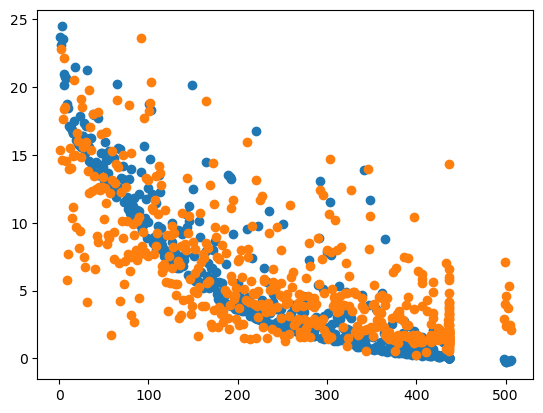

In [30]:
plt.scatter(result['Actual Rank'], result['Actual PPR/G'])
plt.scatter(result['Actual Rank'], result['Predicted PPR/G'])

# Rookies

In [31]:
rookies.head()

,Player,Year,Tm,FantPos,Age,G,GS,GS/G,Cmp/G,Pass_Att/G,...,Rec_Yds/G,Y/R,Rec_TD/G,Fmb/G,FL/G,Tot_TD/G,PPR/G,PPR,Tm_Last_Yr,Changed_Teams
0,A.J. Brown,2019,TEN,WR,22.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13.568750,217.1,None,1
23,A.T. Perry,2023,NOR,WR,24.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.060000,60.6,None,1
25,AJ Dillon,2020,GNB,RB,22.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.663636,40.3,None,1
32,Aaron Fuller,2021,SEA,WR,24.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,None,1
34,Aaron Jones,2017,GNB,RB,23.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.666667,80.0,None,1


In [32]:
rookies.to_sql('rookies', conn, if_exists='replace', index=False)

1027

In [33]:
# joining rookies with college stats
rookie_stats_pg = pd.read_sql('''
    WITH temp AS (
        SELECT 
            Player, Year, Tm, FantPos, Age, "PPR/G", PPR FROM rookies
    )
    SELECT 
        t.Player, t.Tm, t.Year, c.Pick, t.FantPos, t.Age, c.School, c.Conf, c.G as G, c.Cmp/G as "Cmp/G", 
        c.Pass_Att/G as "Pass_Att/G", c.Cmp_Pct, c.Pass_Yds/G as "Pass_Yds/G", c."Pass_Y/A", c.Pass_TD/G as "Pass_TD/G",
        c.Int/G as "Int/G", c.PR, c.Rush_Att/G as "Rush_Att/G", c.Rush_Yds/G as "Rush_Yds/G", c."Rush_Y/A", 
        c.Rush_TD/G as "Rush_TD/G", c.Rec/G as "Rec/G", c.Rec_Yds/G as "Rec_Yds/G", c."Y/R", c.Rec_TD/G as "Rec_TD/G", 
        c.Plays/G as "Plays/G", c.Tot_Yds/G as "Tot_Yds/G", c."Y/P", c.Tot_TD/G as "Tot_TD/G", t."PPR/G", t.PPR
    FROM 
        temp t
    LEFT JOIN 
        college_stats c
    ON
        t.Player = c.Player'''
    , conn)
rookie_stats_pg.dropna(subset=['G'], inplace=True) # na rows are undrafted players
rookie_stats_pg

,Player,Tm,Year,Pick,FantPos,Age,School,Conf,G,Cmp/G,...,Rec/G,Rec_Yds/G,Y/R,Rec_TD/G,Plays/G,Tot_Yds/G,Y/P,Tot_TD/G,PPR/G,PPR
0,A.J. Brown,TEN,2019,51.0,WR,22.0,Ole Miss,SEC,12.0,0.0,...,7.083333,110.000000,15.5,0.500000,7.083333,110.000000,15.5,0.500000,13.568750,217.1
1,A.T. Perry,NOR,2023,195.0,WR,24.0,Wake Forest,ACC,13.0,0.0,...,6.230769,84.307692,13.5,0.846154,6.230769,84.307692,13.5,0.846154,6.060000,60.6
2,AJ Dillon,GNB,2020,62.0,RB,22.0,Boston College,ACC,13.0,0.0,...,1.000000,15.000000,15.0,0.076923,25.461538,144.615385,5.7,1.153846,3.663636,40.3
4,Aaron Jones,GNB,2017,182.0,RB,23.0,UTEP,CUSA,12.0,0.0,...,2.333333,19.416667,8.3,0.250000,21.416667,167.166667,7.8,1.666667,6.666667,80.0
7,Adam Shaheen,CHI,2017,45.0,FB,23.0,Ashland,G-MAC,11.0,0.0,...,6.363636,73.000000,11.5,0.909091,6.363636,73.000000,11.5,0.909091,3.284615,42.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,Zack Moss,BUF,2020,86.0,RB,23.0,Utah,Pac-12,13.0,0.0,...,2.153846,29.846154,13.9,0.153846,20.230769,138.769231,6.9,1.307692,7.815385,101.6
1022,Zamir White,LVR,2022,122.0,RB,23.0,Georgia,SEC,15.0,0.0,...,0.600000,5.000000,8.3,0.000000,11.266667,62.066667,5.5,0.733333,0.500000,7.0
1023,Zander Horvath,LAC,2022,260.0,FB,24.0,Purdue,Big Ten,8.0,0.0,...,2.125000,13.500000,6.4,0.000000,13.500000,53.500000,4.0,0.375000,1.240000,18.6
1024,Zay Flowers,BAL,2023,22.0,WR,23.0,Boston College,ACC,12.0,0.0,...,6.500000,89.750000,13.8,1.000000,7.500000,93.083333,12.4,1.000000,12.900000,206.4


In [34]:
corr_mat = rookie_stats_pg.drop(['Player', 'Year', 'Tm', 'FantPos', 'School', 'Conf'], axis=1).corr()
corr_mat['PPR/G'].sort_values(ascending=False)
# unsurprisingly none of the stats have that good of a correlation with PPR/G
# where the player was picked is the best feature

PPR/G         1.000000
PPR           0.907427
Pass_TD/G     0.223141
Pass_Yds/G    0.219681
Cmp/G         0.216304
PR            0.215885
Pass_Y/A      0.215053
Pass_Att/G    0.213399
Cmp_Pct       0.213358
Int/G         0.203757
Rush_TD/G     0.179851
Rush_Att/G    0.154480
Rush_Yds/G    0.133797
Tot_TD/G      0.099287
Plays/G       0.073777
Tot_Yds/G     0.069228
Rush_Y/A      0.022913
G             0.011890
Rec_TD/G     -0.021237
Rec/G        -0.033980
Rec_Yds/G    -0.034724
Y/R          -0.166489
Y/P          -0.179265
Age          -0.295967
Pick         -0.473665
Name: PPR/G, dtype: float64

In [35]:
# rookies features
rookie_features_pg = rookie_stats_pg.drop(['Player', 'Tm', 'FantPos', 'School', 'Conf', 'PPR', 'PPR/G'], axis=1)
rookie_info_pg = rookie_stats_pg[['Player', 'Year', 'Tm', 'FantPos', 'Age', 'School']]
rookie_PPR_pg = rookie_stats_pg[['Year', 'PPR/G']][rookie_stats_pg['Year'] < 2024].reset_index(drop=True)

# scaling the data
scaler_rookies = StandardScaler()
rookie_features_pg = pd.DataFrame(scaler_rookies.fit_transform(rookie_features_pg), columns=rookie_features_pg.columns)
scalerPPR_rookies = StandardScaler() 
rookie_PPR_pg = pd.DataFrame(scalerPPR_rookies.fit_transform(rookie_PPR_pg['PPR/G'].values.reshape(-1,1)), columns=['PPR/G'])
rookie_features_pg['Year'] = rookie_stats_pg['Year'].reset_index(drop=True)
rookie_PPR_pg['Year'] = rookie_stats_pg['Year'][rookie_stats_pg['Year'] < 2024].reset_index(drop=True)

# saving 2024 data
rookie_features_pg_2024 = rookie_features_pg[rookie_features_pg['Year'] == 2024].reset_index(drop=True).drop('Year', axis=1)
rookie_features_pg = rookie_features_pg[rookie_features_pg['Year'] < 2024].reset_index(drop=True)
rookie_info_pg_2024 = rookie_info_pg[rookie_info_pg['Year'] == 2024].reset_index(drop=True)
rookie_info_pg = rookie_info_pg[rookie_info_pg['Year'] < 2024].reset_index(drop=True)

In [36]:
# linear regression rookies
lr = LinearRegression()
results = cross_validate(lr, rookie_features_pg.drop('Year', axis=1), rookie_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")
# as expected the fit is bad because the data is not great

Train MSE: [0.57922927 0.59188628 0.60639989 0.60732657 0.59795266 0.59580288
 0.57216249 0.58603659 0.59555915 0.58117317 0.57122766 0.57733658]
Test MSE: [0.75433366 0.61979759 0.45955107 0.51464266 0.5498298  0.56771587
 0.84997597 0.71414141 0.60849086 0.81861677 0.86413897 0.78801645]
Mean Train MSE: 0.5885077668058625
Mean Test MSE: 0.675770923413464


In [37]:
# the data is overfit a little bit and since most of the stats aren't highly correlated I'm going to use less features
# I chose PR, Tot_Yds/G, and Tot_TD/G because they are combined stats and represent all of the other stats
# PR (passer rating) is calculated from attempts, completions, yards, tds, and ints
lr = LinearRegression()
results = cross_validate(lr, rookie_features_pg[['Pick', 'Age', 'PR', 'Tot_Yds/G', 'Tot_TD/G']], rookie_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.59097204 0.61538407 0.621464   0.62804706 0.62034012 0.61324177
 0.59754978 0.60738284 0.61704546 0.60032376 0.5920457  0.60057781]
Test MSE: [0.81293673 0.54792758 0.4886221  0.4083338  0.49667872 0.5712369
 0.74703484 0.63435809 0.52703764 0.72898203 0.8271567  0.71208367]
Mean Train MSE: 0.6086978666931028
Mean Test MSE: 0.6251990680922582


In [38]:
# fit was a little better so I'm going to continue using only those stats
rookie_features_pg = rookie_features_pg[['Year', 'Pick', 'Age', 'PR', 'Tot_Yds/G', 'Tot_TD/G']]
rookie_features_pg.head()

,Year,Pick,Age,PR,Tot_Yds/G,Tot_TD/G
0,2019,-0.893356,-0.608477,-0.386174,0.854419,-0.346042
1,2023,1.062569,1.177698,-0.386174,0.266840,0.373470
2,2020,-0.743945,-0.608477,-0.386174,1.646068,1.013037
3,2017,0.885993,0.284610,-0.386174,2.161813,2.078981
4,2017,-0.974853,0.284610,-0.386174,0.008234,0.504291


In [39]:
# gradient boosted regression rookies
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.001,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)
results = cross_validate(gbr, rookie_features_pg.drop('Year', axis=1), rookie_PPR_pg['PPR/G'], cv=kf, scoring='neg_mean_squared_error', return_train_score=True)

print(f"Train MSE: {-results['train_score']}")
print(f"Test MSE: {-results['test_score']}")
print(f"Mean Train MSE: {np.mean(-results['train_score'])}")
print(f"Mean Test MSE: {np.mean(-results['test_score'])}")

Train MSE: [0.40245115 0.39086631 0.40366088 0.41259056 0.40185566 0.3991404
 0.39108384 0.38966439 0.39155351 0.39105943 0.39261462 0.38087517]
Test MSE: [0.65360325 0.64750516 0.46177658 0.31606128 0.48713095 0.56291435
 0.78711706 0.63866082 0.62045858 0.64107026 0.80071718 0.84227919]
Mean Train MSE: 0.39561799337988895
Mean Test MSE: 0.6216078879538222


In [40]:
# data and parameters
X_tensor = torch.tensor(rookie_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_tensor = torch.tensor(rookie_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
learning_rate = 0.001
num_epochs = 1000
input_size = X_tensor.shape[1]
hidden_size = int(X_tensor.shape[1]*2/3)
output_size = 1
criterion = nn.MSELoss()
model = SimpleNN(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# cross validation
fold_results = []
for fold, (train_idx, test_idx) in enumerate(kf.split(X_tensor)):
    X_train = X_tensor[train_idx]
    y_train = y_tensor[train_idx]
    X_test = X_tensor[test_idx]
    y_test = y_tensor[test_idx]
    
    # initialize the model, loss function, and optimizer
    model = SimpleNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # train the model
    train(model, criterion, optimizer, num_epochs, X_train, y_train)
    
    # validate the model
    val_loss = evaluate(model, X_train, y_train, X_test, y_test)
    print(f'Fold {fold + 1}')
    print(f'Train MSE: {val_loss[0]}')
    print(f'Test MSE: {val_loss[1]}\n')
    fold_results.append(val_loss)

fold_results = np.array(fold_results)
print(f'Mean Train Loss: {np.mean(fold_results[:,0])}')
print(f'Mean Test Loss: {np.mean(fold_results[:,1])}')

Fold 1
Train MSE: 0.5541864633560181
Test MSE: 0.7565121650695801

Fold 2
Train MSE: 0.5607436299324036
Test MSE: 0.5887058973312378

Fold 3
Train MSE: 0.6276953816413879
Test MSE: 0.5000346899032593

Fold 4
Train MSE: 0.6429643034934998
Test MSE: 0.4725070297718048

Fold 5
Train MSE: 0.5800713300704956
Test MSE: 0.41410306096076965

Fold 6
Train MSE: 0.5907991528511047
Test MSE: 0.6231802701950073

Fold 7
Train MSE: 0.5459171533584595
Test MSE: 0.7435324192047119

Fold 8
Train MSE: 0.5725364089012146
Test MSE: 0.7071459293365479

Fold 9
Train MSE: 0.6375826597213745
Test MSE: 0.5230851173400879

Fold 10
Train MSE: 0.5622957944869995
Test MSE: 0.6568413972854614

Fold 11
Train MSE: 0.6711418032646179
Test MSE: 0.817825973033905

Fold 12
Train MSE: 0.6610419750213623
Test MSE: 0.7015196084976196

Mean Train Loss: 0.6005813479423523
Mean Test Loss: 0.625416100025177


In [41]:
# 2023 data
rookie_features_pg_2023 = rookie_features_pg[rookie_features_pg['Year']==2023].drop('Year', axis=1)
rookie_PPR_pg_2023 = rookie_PPR_pg[rookie_PPR_pg['Year']==2023].drop('Year', axis=1)
rookie_info_pg_2023 = rookie_info_pg[rookie_info_pg['Year']==2023]

In [42]:
# train and test data
X_train = torch.tensor(rookie_features_pg[rookie_features_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(rookie_PPR_pg[rookie_PPR_pg['Year'] < 2023].drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(rookie_features_pg_2023.values, dtype=torch.float32)
y_test = torch.tensor(rookie_PPR_pg_2023.values, dtype=torch.float32)

# parameters
input_size = X_train.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# training loop
model.train()
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluating the model
model.eval()  
with torch.no_grad():  
    train_predict = model(X_train)
    test_predict = model(X_test)

    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())
    test_mse = mean_squared_error(y_test.numpy(), test_predict.numpy())

print(f'Train Loss: {train_mse}')
print(f'Test Loss: {test_mse}')

Epoch [100/1000], Loss: 1.0767
Epoch [200/1000], Loss: 0.9039
Epoch [300/1000], Loss: 0.7954
Epoch [400/1000], Loss: 0.7353
Epoch [500/1000], Loss: 0.6991
Epoch [600/1000], Loss: 0.6763
Epoch [700/1000], Loss: 0.6642
Epoch [800/1000], Loss: 0.6582
Epoch [900/1000], Loss: 0.6548
Epoch [1000/1000], Loss: 0.6336
Train Loss: 0.6333615779876709
Test Loss: 0.7392052412033081


In [43]:
# I think this good for now, try other models later like ridge regression because data is overfit

In [44]:
# saving predictions
result = pd.DataFrame({'Actual PPR/G': rookie_PPR_pg_2023.values.flatten(), 'Predicted PPR/G': test_predict.flatten()})
result = pd.concat([rookie_info_pg_2023.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['Actual PPR/G'] = rookie_stats_pg['PPR/G'][rookie_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR/G'] = scalerPPR_rookies.inverse_transform(result['Predicted PPR/G'].values.reshape(-1,1))
result['Actual PPR'] = rookie_stats_pg['PPR'][rookie_stats_pg['Year']==2023].reset_index(drop=True)
result['Predicted PPR'] = result['Predicted PPR/G']*16
result['Predicted Rank'] = result['Predicted PPR'].rank(ascending=False, method='min').astype(int)
result['Actual Rank'] = result['Actual PPR'].rank(ascending=False, method='min').astype(int)
result.sort_values('Predicted Rank', inplace=True)

pred_rookies_2023 = result.copy()
pred_rookies_2023

,Player,Year,Tm,FantPos,Age,School,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Predicted Rank,Actual Rank
4,Bijan Robinson,2023,ATL,RB,21.0,Texas,14.488235,12.043493,246.3,192.695892,1,3
29,Jahmyr Gibbs,2023,DET,RB,21.0,Alabama,16.140000,10.099075,242.1,161.585205,2,4
67,Zach Charbonnet,2023,SEA,RB,22.0,UCLA,6.631250,10.022668,106.1,160.362686,3,21
33,Jaxon Smith-Njigba,2023,SEA,WR,21.0,Ohio State,8.811765,9.974147,149.8,159.586349,4,16
9,C.J. Stroud,2023,HOU,QB,22.0,Ohio State,18.400000,9.477157,276.0,151.634506,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...
69,Zack Kuntz,2023,NYJ,TE,24.0,Old Dominion,0.000000,0.868130,0.0,13.890085,67,69
5,Bo Melton,2023,GNB,WR,24.0,Rutgers,9.180000,0.729859,45.9,11.677752,68,36
30,Jalen Brooks,2023,DAL,WR,23.0,South Carolina,1.771429,0.598769,12.4,9.580301,69,59
54,Ronnie Bell,2023,SFO,WR,23.0,Michigan,1.811765,0.441296,30.8,7.060740,70,46


In [45]:
# combining non rookies and rookies
pred_all_2023 = pd.concat([pred_2023, pred_rookies_2023.drop('School', axis=1)]).reset_index(drop=True)
pred_all_2023.drop(['Predicted Rank', 'Actual Rank'], axis=1, inplace=True)
pred_all_2023.head()

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR
0,Cooper Kupp,2023,LAR,WR,30.0,13.700000,23.613802,164.4,377.820831
1,Josh Allen,2023,BUF,QB,27.0,23.094118,22.781282,392.6,364.500519
2,Jalen Hurts,2023,PHI,QB,25.0,20.988235,22.104677,356.8,353.674835
3,Patrick Mahomes,2023,KAN,QB,28.0,17.512500,20.477882,280.2,327.646118
4,Kyler Murray,2023,ARI,QB,26.0,18.300000,20.400696,146.4,326.411133


In standard fantasy league formats (which is what I play with) each team starts 1 qb, 2 rbs, 2 wr, 1 te, and 1 flex (rb/wr/te). Because of this different positions are valued differently. Rbs are generally the most valued because each team needs 2 and they are relatively the most scarce. Qbs are the last valued because even though they are the highest scoring position, each team only needs and they are relatively the most scarce. Wrs are valued slightly less than rbs because they score around the same as rbs but there are more of them. Tes are valued similarly to rbs because they don't score as much but they are very scarce. If I make my overall rankings by sorting all the players by predicted PPR, my rankings will have qbs too high, so I need to account for this in my overall rankings. I did some research online and found that qbs are generally 70% as valuable as other positions so I'll start from there and see how it looks. I think I will also make some slight adjustments to rbs, wrs, and tes. 

In [46]:
# creating Adj PPR that adjusts for positional value
pred_all_2023['Adj Predicted PPR'] = pred_all_2023['Predicted PPR']
pred_all_2023.loc[pred_all_2023['FantPos']=='QB', 'Adj Predicted PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='QB', 'Predicted PPR']*0.7
pred_all_2023.loc[pred_all_2023['FantPos']=='WR', 'Adj Predicted PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='WR', 'Predicted PPR']*0.95
pred_all_2023.loc[pred_all_2023['FantPos']=='TE', 'Adj Predicted PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='TE', 'Predicted PPR']*1.05

pred_all_2023['Adj Actual PPR'] = pred_all_2023['Actual PPR']
pred_all_2023.loc[pred_all_2023['FantPos']=='QB', 'Adj Actual PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='QB', 'Actual PPR']*0.7
pred_all_2023.loc[pred_all_2023['FantPos']=='WR', 'Adj Actual PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='WR', 'Actual PPR']*0.95
pred_all_2023.loc[pred_all_2023['FantPos']=='TE', 'Adj Actual PPR'] = pred_all_2023.loc[pred_all_2023['FantPos']=='TE', 'Actual PPR']*1.05

pred_all_2023['Predicted OvRank'] = pred_all_2023['Adj Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_all_2023['Actual OvRank'] = pred_all_2023['Adj Actual PPR'].rank(ascending=False, method='min').astype(int)

pred_all_2023.sort_values('Predicted OvRank', inplace=True)
pred_all_2023.head()

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Adj Predicted PPR,Adj Actual PPR,Predicted OvRank,Actual OvRank
0,Cooper Kupp,2023,LAR,WR,30.0,13.700000,23.613802,164.4,377.820831,358.929790,156.18,1,103
5,Derrick Henry,2023,TEN,RB,29.0,14.511765,19.740007,246.7,315.840118,315.840118,246.70,2,23
10,Austin Ekeler,2023,LAC,RB,28.0,13.242857,18.650959,185.4,298.415344,298.415344,185.40,3,80
6,Davante Adams,2023,LVR,WR,31.0,15.611765,19.086031,265.4,305.376495,290.107671,252.13,4,18
7,Justin Jefferson,2023,MIN,WR,24.0,20.220000,19.041512,202.2,304.664185,289.430975,192.09,5,71


In [47]:
# splitting up by position
pred_qb_2023 = pred_all_2023[pred_all_2023['FantPos']=='QB'].reset_index(drop=True)
pred_rb_2023 = pred_all_2023[pred_all_2023['FantPos']=='RB'].reset_index(drop=True)
pred_wr_2023 = pred_all_2023[pred_all_2023['FantPos']=='WR'].reset_index(drop=True)
pred_te_2023 = pred_all_2023[pred_all_2023['FantPos']=='TE'].reset_index(drop=True)

pred_qb_2023['Predicted PosRank'] = pred_qb_2023['Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_qb_2023['Actual PosRank'] = pred_qb_2023['Actual PPR'].rank(ascending=False, method='min').astype(int)
pred_rb_2023['Predicted PosRank'] = pred_rb_2023['Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_rb_2023['Actual PosRank'] = pred_rb_2023['Actual PPR'].rank(ascending=False, method='min').astype(int)
pred_wr_2023['Predicted PosRank'] = pred_wr_2023['Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_wr_2023['Actual PosRank'] = pred_wr_2023['Actual PPR'].rank(ascending=False, method='min').astype(int)
pred_te_2023['Predicted PosRank'] = pred_te_2023['Predicted PPR'].rank(ascending=False, method='min').astype(int)
pred_te_2023['Actual PosRank'] = pred_te_2023['Actual PPR'].rank(ascending=False, method='min').astype(int)

pred_qb_2023.sort_values('Predicted PosRank', inplace=True)
pred_rb_2023.sort_values('Predicted PosRank', inplace=True)
pred_wr_2023.sort_values('Predicted PosRank', inplace=True)
pred_te_2023.sort_values('Predicted PosRank', inplace=True)

pred_qb_2023.head()

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Adj Predicted PPR,Adj Actual PPR,Predicted OvRank,Actual OvRank,Predicted PosRank,Actual PosRank
0,Josh Allen,2023,BUF,QB,27.0,23.094118,22.781282,392.6,364.500519,255.150363,274.82,11,9,1,1
1,Jalen Hurts,2023,PHI,QB,25.0,20.988235,22.104677,356.8,353.674835,247.572385,249.76,13,20,2,2
2,Patrick Mahomes,2023,KAN,QB,28.0,17.512500,20.477882,280.2,327.646118,229.352283,196.14,22,66,3,8
3,Kyler Murray,2023,ARI,QB,26.0,18.300000,20.400696,146.4,326.411133,228.487793,102.48,23,159,4,26
4,Deshaun Watson,2023,CLE,QB,28.0,14.466667,18.946957,86.8,303.151306,212.205914,60.76,34,224,5,34


In [48]:
# recombining positions
pred_all_2023 = pd.concat([pred_qb_2023, pred_rb_2023, pred_wr_2023, pred_te_2023]).reset_index(drop=True)
pred_all_2023.sort_values('Predicted OvRank', inplace=True)
pred_all_2023

,Player,Year,Tm,FantPos,Age,Actual PPR/G,Predicted PPR/G,Actual PPR,Predicted PPR,Adj Predicted PPR,Adj Actual PPR,Predicted OvRank,Actual OvRank,Predicted PosRank,Actual PosRank
212,Cooper Kupp,2023,LAR,WR,30.0,13.700000,23.613802,164.4,377.820831,358.929790,156.18,1,103,1,40
79,Derrick Henry,2023,TEN,RB,29.0,14.511765,19.740007,246.7,315.840118,315.840118,246.70,2,23,1,8
80,Austin Ekeler,2023,LAC,RB,28.0,13.242857,18.650959,185.4,298.415344,298.415344,185.40,3,80,2,26
213,Davante Adams,2023,LVR,WR,31.0,15.611765,19.086031,265.4,305.376495,290.107671,252.13,4,18,2,10
214,Justin Jefferson,2023,MIN,WR,24.0,20.220000,19.041512,202.2,304.664185,289.430975,192.09,5,71,3,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Easton Stick,2023,LAC,QB,28.0,13.520000,2.942783,67.6,0.000000,0.000000,47.32,572,256,74,38
75,Matt Barkley,2023,JAX,QB,33.0,-0.300000,4.594203,-0.3,0.000000,0.000000,-0.21,572,572,74,76
74,C.J. Beathard,2023,JAX,QB,30.0,3.071429,3.442077,21.5,0.000000,0.000000,15.05,572,387,74,54
73,Kyle Trask,2023,TAM,QB,25.0,-0.050000,2.899520,-0.1,0.000000,0.000000,-0.07,572,569,74,74


I'm happy with my model's predictions for now so I'm going to train the models and predict for the upcoming 2024 season. I will come back and try other models and finetune new and existing models

# 2024 Predictions

In [182]:
# I made player_features 2024 and player_info_2024 earlier
player_features_pg_2024.head()

,G,GS,GS/G,Cmp/G,Pass_Att/G,Pass_Yds/G,Pass_TD/G,Int/G,Rush_Att/G,Rush_Yds/G,...,Rush_TD/G,Tgt/G,Rec/G,Rec_Yds/G,Y/R,Rec_TD/G,Fmb/G,FL/G,Tot_TD/G,Changed_Teams
0,1.348001,2.068343,1.387512,-0.343439,-0.346616,-0.341151,-0.322736,-0.330301,-0.533764,-0.515803,...,-0.462313,2.487027,2.378459,3.183168,1.519241,2.643779,0.106551,0.867055,1.619737,0
1,-1.186766,-0.766751,-0.428509,-0.343439,-0.346616,-0.341151,-0.322736,-0.330301,-0.533764,-0.515803,...,-0.462313,-0.287704,-0.280875,0.263341,0.524929,1.811036,-0.585900,-0.536162,0.995025,0
2,1.136770,-0.199733,-0.479286,-0.343439,-0.346616,-0.341151,-0.322736,-0.330301,2.214800,1.813391,...,1.316514,-0.124324,-0.066931,-0.261924,0.233626,-0.762896,-0.401968,-0.536162,0.421781,0
3,0.714309,1.595827,1.467162,-0.343439,-0.346616,-0.341151,-0.322736,-0.330301,2.529785,2.904487,...,0.441218,0.612452,0.886861,0.161447,-0.061560,0.615996,0.885558,1.167744,0.788140,1
4,-0.341844,0.650796,1.467162,2.929062,2.897285,2.731589,3.052665,2.445516,-0.077348,-0.234361,...,-0.110940,-0.989994,-0.989105,-0.891010,-1.465638,-0.762896,2.030026,2.114358,-0.667719,0


In [183]:
# train and test data
X_train = torch.tensor(player_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(player_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(player_features_pg_2024.values, dtype=torch.float32)

# parameters
input_size = X_train.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# training loop
model.train()
for epoch in range(num_epochs):
    # forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluating the model
model.eval()  
with torch.no_grad():  
    train_predict = model(X_train)
    test_predict = model(X_test)
    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())

print(f'Train Loss: {train_mse}')

Epoch [100/1000], Loss: 0.4154
Epoch [200/1000], Loss: 0.3760
Epoch [300/1000], Loss: 0.3622
Epoch [400/1000], Loss: 0.3557
Epoch [500/1000], Loss: 0.3507
Epoch [600/1000], Loss: 0.3467
Epoch [700/1000], Loss: 0.3431
Epoch [800/1000], Loss: 0.3402
Epoch [900/1000], Loss: 0.3378
Epoch [1000/1000], Loss: 0.3356
Train Loss: 0.3355446457862854


In [184]:
# saving predictions
result = pd.DataFrame({'PPR/G': test_predict.flatten()})
result = pd.concat([player_info_pg_2024.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['PPR/G'] = scalerPPR.inverse_transform(result['PPR/G'].values.reshape(-1,1))
result['PPR'] = result['PPR/G']*16
result.loc[result['FantPos'] == 'QB', 'PPR'] = (result['PPR/G'] * player_stats_pg_2024['GS/G'].reset_index(drop=True) * 16)
result.sort_values('PPR', ascending=False, inplace=True)

pred_2024 = result.copy()
pred_2024.head()

,Player,Year,Tm,FantPos,Age,PPR/G,PPR
131,Josh Allen,2024,BUF,QB,28.0,22.017731,352.283691
221,Tyreek Hill,2024,MIA,WR,30.0,21.671307,346.740906
107,Jalen Hurts,2024,PHI,QB,26.0,20.973289,335.572632
32,CeeDee Lamb,2024,DAL,WR,25.0,20.737501,331.800018
156,Lamar Jackson,2024,BAL,QB,27.0,19.768307,316.292908


In [185]:
# I also made rookie_features_2024 and rookie_info_2024 earlier
rookie_features_pg_2024 = rookie_features_pg_2024[['Pick', 'Age', 'PR', 'Tot_Yds/G', 'Tot_TD/G']]
rookie_features_pg_2024.head()

,Pick,Age,PR,Tot_Yds/G,Tot_TD/G
0,-0.879773,-0.608477,-0.386174,-0.279273,0.247841
1,0.410594,-0.608477,-0.386174,1.165068,1.732549
2,-0.866190,0.284610,-0.386174,-0.372930,-0.346042
3,-0.458706,1.177698,-0.386174,0.415318,2.494699
4,-1.423086,2.070785,3.093090,-1.661266,-1.385338


In [186]:
# train and test data
X_train = torch.tensor(rookie_features_pg.drop('Year', axis=1).values, dtype=torch.float32)
y_train = torch.tensor(rookie_PPR_pg.drop('Year', axis=1).values, dtype=torch.float32)
X_test = torch.tensor(rookie_features_pg_2024.values, dtype=torch.float32)

# paramters
input_size = X_train.shape[1]
hidden_size = int(X_train.shape[1]*2/3)
output_size = 1
model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000

# training loop
model.train()
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# evaluating the model
model.eval()  
with torch.no_grad(): 
    train_predict = model(X_train)
    test_predict = model(X_test)
    train_mse = mean_squared_error(y_train.numpy(), train_predict.numpy())

print(f'Train Loss: {train_mse}')

Epoch [100/1000], Loss: 0.9586
Epoch [200/1000], Loss: 0.8099
Epoch [300/1000], Loss: 0.6874
Epoch [400/1000], Loss: 0.6167
Epoch [500/1000], Loss: 0.5912
Epoch [600/1000], Loss: 0.5758
Epoch [700/1000], Loss: 0.5676
Epoch [800/1000], Loss: 0.5626
Epoch [900/1000], Loss: 0.5594
Epoch [1000/1000], Loss: 0.5577
Train Loss: 0.557647168636322


In [187]:
# saving predictions
result = pd.DataFrame({'PPR/G': test_predict.flatten()})
result = pd.concat([rookie_info_pg_2024.reset_index(drop=True), result.reset_index(drop=True)], axis=1)
result['PPR/G'] = scalerPPR_rookies.inverse_transform(result['PPR/G'].values.reshape(-1,1))
result['PPR'] = result['PPR/G']*16
result.sort_values('PPR', ascending=False, inplace=True)

pred_rookies_2024 = result.copy()
pred_rookies_2024.head()

,Player,Year,Tm,FantPos,Age,School,PPR/G,PPR
18,Jayden Daniels,2024,WAS,QB,24.0,LSU,13.060035,208.960556
9,Caleb Williams,2024,CHI,QB,23.0,USC,12.683383,202.934128
13,J.J. McCarthy,2024,MIN,QB,22.0,Michigan,12.677481,202.839691
29,Malik Nabers,2024,NYG,WR,22.0,LSU,12.236936,195.790970
11,Drake Maye,2024,NWE,QB,23.0,North Carolina,12.090422,193.446747


In [188]:
# combining both predictions (non rookies and rookies)
pred_all_2024 = pd.concat([pred_2024, pred_rookies_2024.drop('School', axis=1)]).reset_index(drop=True)
pred_all_2024['PPR/G'] = pred_all_2024['PPR/G'].astype('float64')
pred_all_2024['Age'] = pred_all_2024['Age'].astype('int')

# adjusting PPR by position
pred_all_2024['Adj PPR'] = pred_all_2024['PPR']
pred_all_2024.loc[pred_all_2024['FantPos']=='QB', 'Adj PPR'] = pred_all_2024.loc[pred_all_2024['FantPos']=='QB', 'PPR']*0.7
pred_all_2024.loc[pred_all_2024['FantPos']=='WR', 'Adj PPR'] = pred_all_2024.loc[pred_all_2024['FantPos']=='WR', 'PPR']*0.95
pred_all_2024.loc[pred_all_2024['FantPos']=='TE', 'Adj PPR'] = pred_all_2024.loc[pred_all_2024['FantPos']=='TE', 'PPR']*1.05
pred_all_2024['OvRank'] = pred_all_2024['Adj PPR'].rank(ascending=False, method='min').astype(int)
pred_all_2024.sort_values('OvRank', inplace=True)
pred_all_2024.drop('Adj PPR', axis=1, inplace=True)

# splitting up by position
pred_qb_2024 = pred_all_2024[pred_all_2024['FantPos']=='QB'].reset_index(drop=True)
pred_rb_2024 = pred_all_2024[pred_all_2024['FantPos']=='RB'].reset_index(drop=True)
pred_wr_2024 = pred_all_2024[pred_all_2024['FantPos']=='WR'].reset_index(drop=True)
pred_te_2024 = pred_all_2024[pred_all_2024['FantPos']=='TE'].reset_index(drop=True)

# making the positional rankings
pred_qb_2024['PosRank'] = pred_qb_2024['PPR'].rank(ascending=False, method='min').astype(int)
pred_rb_2024['PosRank'] = pred_rb_2024['PPR'].rank(ascending=False, method='min').astype(int)
pred_wr_2024['PosRank'] = pred_wr_2024['PPR'].rank(ascending=False, method='min').astype(int)
pred_te_2024['PosRank'] = pred_te_2024['PPR'].rank(ascending=False, method='min').astype(int)

pred_qb_2024.sort_values('PosRank', inplace=True)
pred_rb_2024.sort_values('PosRank', inplace=True)
pred_wr_2024.sort_values('PosRank', inplace=True)
pred_te_2024.sort_values('PosRank', inplace=True)

# recombining the positions into one dataframe
pred_all_2024 = pd.concat([pred_qb_2024, pred_rb_2024, pred_wr_2024, pred_te_2024]).reset_index(drop=True)
pred_all_2024.sort_values('OvRank', inplace=True)

In [189]:
# reordering and rounding columns
new_order = ['OvRank', 'PosRank', 'Player', 'Year', 'Tm', 'FantPos', 'Age', 'PPR/G', 'PPR']
pred_all_2024 = pred_all_2024[new_order].round(2)
pred_qb_2024 = pred_qb_2024[new_order].round(2)
pred_rb_2024 = pred_rb_2024[new_order].round(2)
pred_wr_2024 = pred_wr_2024[new_order].round(2)
pred_te_2024 = pred_te_2024[new_order].round(2)

pred_all_2024.head()

,OvRank,PosRank,Player,Year,Tm,FantPos,Age,PPR/G,PPR
115,1,1,Tyreek Hill,2024,MIA,WR,30,21.67,346.74
116,2,2,CeeDee Lamb,2024,DAL,WR,25,20.74,331.80
37,3,1,Christian McCaffrey,2024,SFO,RB,28,19.33,309.29
117,4,3,Justin Jefferson,2024,MIN,WR,25,19.30,308.82
118,5,4,Puka Nacua,2024,LAR,WR,23,18.59,297.50


In [190]:
pred_qb_2024.head()

,OvRank,PosRank,Player,Year,Tm,FantPos,Age,PPR/G,PPR
0,10,1,Josh Allen,2024,BUF,QB,28,22.02,352.28
1,13,2,Jalen Hurts,2024,PHI,QB,26,20.97,335.57
2,22,3,Lamar Jackson,2024,BAL,QB,27,19.77,316.29
3,33,4,Patrick Mahomes,2024,KAN,QB,29,18.48,295.61
4,42,5,Justin Fields,2024,PIT,QB,25,17.68,282.87


In [191]:
pred_rb_2024.head()

,OvRank,PosRank,Player,Year,Tm,FantPos,Age,PPR/G,PPR
0,3,1,Christian McCaffrey,2024,SFO,RB,28,19.33,309.29
1,14,2,Breece Hall,2024,NYJ,RB,23,14.55,232.74
2,17,3,Bijan Robinson,2024,ATL,RB,22,14.01,224.12
3,18,4,De'Von Achane,2024,MIA,RB,23,13.99,223.80
4,21,5,Nick Chubb,2024,CLE,RB,29,13.87,221.84


In [192]:
pred_wr_2024.head()

,OvRank,PosRank,Player,Year,Tm,FantPos,Age,PPR/G,PPR
0,1,1,Tyreek Hill,2024,MIA,WR,30,21.67,346.74
1,2,2,CeeDee Lamb,2024,DAL,WR,25,20.74,331.80
2,4,3,Justin Jefferson,2024,MIN,WR,25,19.30,308.82
3,5,4,Puka Nacua,2024,LAR,WR,23,18.59,297.50
4,6,5,Amon-Ra St. Brown,2024,DET,WR,25,18.29,292.62


In [193]:
pred_te_2024.head()

,OvRank,PosRank,Player,Year,Tm,FantPos,Age,PPR/G,PPR
0,7,1,Travis Kelce,2024,KAN,TE,35,15.82,253.05
1,25,2,Sam LaPorta,2024,DET,TE,23,12.78,204.45
2,28,3,T.J. Hockenson,2024,MIN,TE,27,12.71,203.37
3,45,4,Evan Engram,2024,JAX,TE,30,11.66,186.60
4,54,5,George Kittle,2024,SFO,TE,31,11.29,180.60


In [194]:
# exporting to csv
pred_all_2024.to_csv('all_players.csv', index=False)
pred_qb_2024.to_csv('qbs.csv', index=False)
pred_rb_2024.to_csv('rbs.csv', index=False)
pred_wr_2024.to_csv('wrs.csv', index=False)
pred_te_2024.to_csv('tes.csv', index=False)

In [62]:
conn.close()